In [1]:
from sklearn.linear_model import LinearRegression
from matplotlib.backends import backend_pdf as bpdf
from covid_functions import *
%matplotlib inline

#Only use data up through April 15
cutoff_time = datetime(2020,4,15)

#Load data from JH repository
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
cases_global = format_JH(base_url+'time_series_covid19_confirmed_global.csv',['Lat','Long'],['Country/Region','Province/State'])
deaths_global = format_JH(base_url+'time_series_covid19_deaths_global.csv',['Lat','Long'],['Country/Region','Province/State'])
cases_US = format_JH(base_url+'time_series_covid19_confirmed_US.csv',['UID','iso2','iso3','code3','FIPS','Lat','Long_','Combined_Key'],['Country_Region','Province_State','Admin2'])
deaths_US = format_JH(base_url+'time_series_covid19_deaths_US.csv',['UID','iso2','iso3','code3','FIPS','Lat','Long_','Combined_Key','Population'],['Country_Region','Province_State','Admin2'])
cases_US = cases_US.T.groupby(level=[0,1]).sum().T
deaths_US = deaths_US.T.groupby(level=[0,1]).sum().T
#Join US and global data into single table
cases = cases_global.join(cases_US).loc[:cutoff_time]
deaths = deaths_global.join(deaths_US).loc[:cutoff_time]

#Load best-fit parameters
params_deaths=pd.read_csv('output/params_deaths_apr15.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
params_cases=pd.read_csv('output/params_cases_apr15.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])

#Load full prediction tables, with confidence bounds
predictions_deaths = format_predictions('output/predictions_deaths_apr15.csv')
predictions_cases = format_predictions('output/predictions_cases_apr15.csv')

# Look at current numbers

In [2]:
deaths.iloc[-1].sort_values(ascending=False).iloc[:70]

Country/Region      Province/State
US                  NaN               28325
Italy               NaN               21645
Spain               NaN               18708
France              NaN               17167
United Kingdom      NaN               12868
US                  New York          11617
Iran                NaN                4777
Belgium             NaN                4440
Germany             NaN                3804
China               Hubei              3222
US                  New Jersey         3156
Netherlands         NaN                3134
US                  Michigan           1921
Brazil              NaN                1736
Turkey              NaN                1518
Switzerland         NaN                1239
Sweden              NaN                1203
US                  Massachusetts      1108
                    Louisiana          1103
                    Illinois            949
                    Connecticut         868
                    California          8

In [3]:
cases.iloc[-1].sort_values(ascending=False).iloc[:100]

Country/Region  Province/State      
US              NaN                     636350
                New York                214454
Spain           NaN                     177644
Italy           NaN                     165155
Germany         NaN                     134753
France          NaN                     133470
United Kingdom  NaN                      98476
Iran            NaN                      76389
US              New Jersey               71030
Turkey          NaN                      69392
China           Hubei                    67803
Belgium         NaN                      33573
US              Massachusetts            29918
Brazil          NaN                      28320
Netherlands     NaN                      28153
US              Michigan                 28059
                Pennsylvania             26753
                California               26686
Switzerland     NaN                      26336
US              Illinois                 24593
Russia          NaN    

# Make fits

In [4]:
params_cases = fit_all(cases,plot=False,ylabel='Confirmed Cases',p0=5e2)
params_deaths = fit_all(deaths,plot=False,ylabel='Fatalities',p0=50)
params_cases.dropna().to_csv('output/params_cases_apr15.csv')
params_deaths.dropna().to_csv('output/params_deaths_apr15.csv')

params_deaths=pd.read_csv('output/params_deaths_apr15.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
params_cases=pd.read_csv('output/params_cases_apr15.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])

# Early exponential to power law behavior

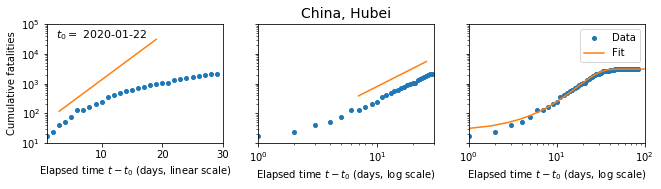

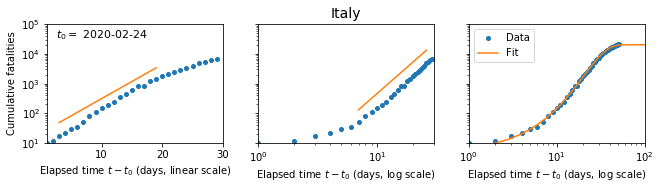

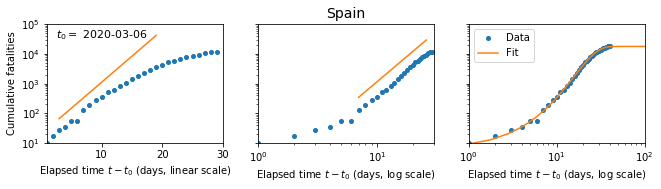

In [5]:
#Set up parameters
start_cutoff = 5
use_times = 30
ms = 4
daymin=-150
daymax=100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

for country,region in [('China','Hubei'),('Italy','NaN'),('Spain','NaN')]:
    #Extract data and best-fit
    data = deaths[country,region]
    params = params_deaths.loc[country,region]

    fig,ax=plt.subplots(1,3,sharey=True,figsize=(10,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    #Plot data
    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    plot_data = plot_data.loc[plot_data.index<use_times]
    t_plot = plot_data.index.values
    ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)

    #Make linear regressions
    fit_early = plot_data.iloc[:7]
    fit_late = plot_data.iloc[7:-3]
    t_fit_early = fit_early.index.values
    t_fit_late = fit_late.index.values
    expo = LinearRegression()
    power = LinearRegression()
    X_all = plot_data.index.values[3:20].reshape(-1,1)
    y_all = np.log(pd.to_numeric(plot_data).iloc[3:20].values)
    X_early = t_fit_early.reshape(-1,1)
    X_late = t_fit_late.reshape(-1,1)
    y_early = np.log(pd.to_numeric(fit_early).values)
    y_late = np.log(pd.to_numeric(fit_late).values)
    expo.fit(X_early,y_early)
    power.fit(np.log(X_late),y_late)
    y_power = power.predict(np.log(X_late))
    y_exp = expo.predict(X_all)
    
    #Plot regressions and erf fit
    ax[1].loglog(X_late.reshape(-1),3*np.exp(y_power))
    ax[0].semilogy(X_all.reshape(-1),3*np.exp(y_exp))
    out = plot_predictions(data,params,ax=ax[2],log_scale=True,conf_type=None,p0=50,t_pred = t_pred)

    #Make labels
    ax[0].set_xlabel(r'Elapsed time $t-t_0$ (days, linear scale)')
    ax[1].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[2].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[0].set_ylabel('Cumulative fatalities')
    ax[0].set_ylim((10,1e5))
    if country == 'China':
        ax[1].set_title(', '.join([country,region]),fontsize=14)
    else:
        ax[1].set_title(country,fontsize=14)
    ax[2].legend()
    ax[0].set_xlim((1,use_times))
    ax[1].set_xlim((1,use_times))
    ax[2].set_xlim((1,100))
    ax[0].text(0.05,0.88,r'$t_0 = $ '+np.datetime_as_string(t0)[:10],fontsize=11,transform=ax[0].transAxes)
    
    #Save
    pdf = bpdf.PdfPages('figures/example_'+country+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

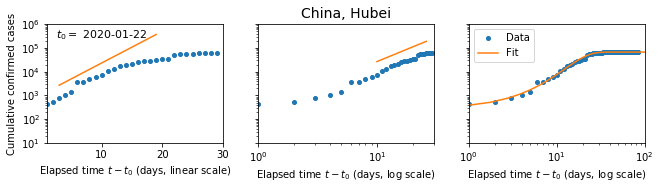

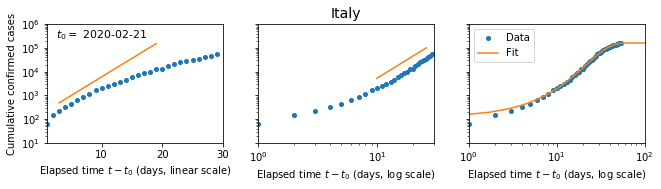

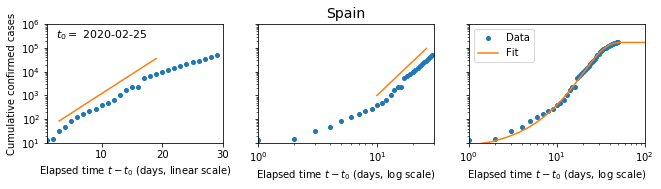

In [6]:
#Set up
start_cutoff = 5
use_times = 30
ms = 4
daymin=-150
daymax=100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

for country,region in [('China','Hubei'),('Italy','NaN'),('Spain','NaN')]:
    #Extract data
    data = cases[country,region]
    params = params_cases.loc[country,region]

    fig,ax=plt.subplots(1,3,sharey=True,figsize=(10,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    #Plot data
    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    plot_data = plot_data.loc[plot_data.index<use_times]
    t_plot = plot_data.index.values
    ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)

    #Make linear regressions for guides to the eye
    fit_early = plot_data.iloc[:14]
    fit_late = plot_data.iloc[10:-3]
    t_fit_early = fit_early.index.values
    t_fit_late = fit_late.index.values
    expo = LinearRegression()
    expo2 = LinearRegression()
    power = LinearRegression()
    X_all = plot_data.index.values[3:20].reshape(-1,1)
    y_all = np.log(pd.to_numeric(plot_data).iloc[3:20].values)
    X_early = t_fit_early.reshape(-1,1)
    X_late = t_fit_late.reshape(-1,1)
    y_early = np.log(pd.to_numeric(fit_early).values)
    y_late = np.log(pd.to_numeric(fit_late).values)
    expo.fit(X_early,y_early)
    power.fit(np.log(X_late),y_late)
    y_power = power.predict(np.log(X_late))
    y_exp = expo.predict(X_all)
    
    #plot regressions and erf fit
    ax[1].loglog(X_late.reshape(-1),3*np.exp(y_power))
    ax[0].semilogy(X_all.reshape(-1),3*np.exp(y_exp))
    out = plot_predictions(data,params,ax=ax[2],log_scale=True,conf_type=None,p0=500,
                           t_pred = t_pred,start_cutoff=start_cutoff)
    
    #Annotate
    ax[0].text(0.05,0.88,r'$t_0 = $ '+np.datetime_as_string(t0)[:10],fontsize=11,transform=ax[0].transAxes)
    ax[0].set_xlabel(r'Elapsed time $t-t_0$ (days, linear scale)')
    ax[1].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[2].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[0].set_ylabel('Cumulative confirmed cases')
    ax[0].set_ylim((10,1e6))
    if country == 'China':
        ax[1].set_title(', '.join([country,region]),fontsize=14)
    else:
        ax[1].set_title(country,fontsize=14)
    ax[2].legend()
    ax[0].set_xlim((1,use_times))
    ax[1].set_xlim((1,use_times))
    ax[2].set_xlim((1,100))
    
    #Save
    pdf = bpdf.PdfPages('figures/example_'+country+'_cases.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

# Make predictions

In [ ]:
print('Total regions = '+str(len(deaths.T)))
print('Analyzed regions = '+str(len(params_deaths.drop((('US','NaN'))).dropna())))
print('Analyzed states = '+str(len(params_deaths.dropna().loc['US'].drop('NaN'))))

Total regions = 322
Analyzed regions = 79
Analyzed states = 30


## Tabulate predictions for all countries and states

In [5]:
predictions_deaths = predict_all(deaths,params_deaths,p0=50)
predictions_deaths.to_csv('output/predictions_deaths_apr15.csv')
predictions_cases = predict_all(cases,params_cases,p0=500)
predictions_cases.to_csv('output/predictions_cases_apr15.csv')

#Load full prediction tables, with confidence bounds
predictions_deaths = format_predictions('output/predictions_deaths_apr15.csv')
predictions_cases = format_predictions('output/predictions_cases_apr15.csv')

Algeria, NaN
Argentina, NaN
Austria, NaN
Belgium, NaN
Brazil, NaN
Canada, Ontario
Canada, Quebec
Chile, NaN
China, Hubei
Colombia, NaN
Czechia, NaN
Denmark, NaN
Dominican Republic, NaN
Ecuador, NaN
Egypt, NaN
France, NaN
Germany, NaN
Greece, NaN
Hungary, NaN
India, NaN
Indonesia, NaN
Iran, NaN
Iraq, NaN
Ireland, NaN
Israel, NaN
Italy, NaN
Japan, NaN
Korea, South, NaN
Luxembourg, NaN
Malaysia, NaN
Mexico, NaN
Morocco, NaN
Netherlands, NaN
Norway, NaN
Pakistan, NaN
Panama, NaN
Peru, NaN
Philippines, NaN
Poland, NaN
Portugal, NaN
Romania, NaN
Russia, NaN
Serbia, NaN
Spain, NaN
Sweden, NaN
Switzerland, NaN
Turkey, NaN
Ukraine, NaN
United Kingdom, NaN
US, NaN
US, Alabama
US, Arizona
US, California
US, Colorado
US, Connecticut
US, Florida
US, Georgia
US, Illinois
US, Indiana
US, Kentucky
US, Louisiana
US, Maryland
US, Massachusetts
US, Michigan
US, Minnesota
US, Mississippi
US, Missouri
US, Nevada
US, New Jersey
US, New York
US, North Carolina
US, Ohio
US, Oklahoma
US, Pennsylvania
US, South

## Plot predictions for top countries

### Fatalities

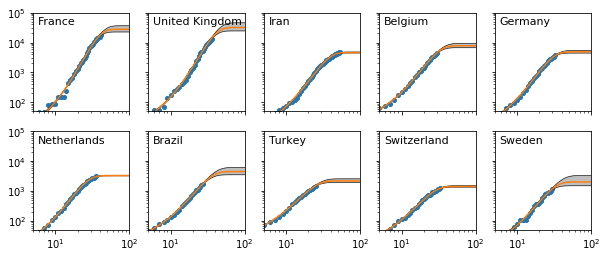

In [7]:
params_list = params_deaths
data = deaths
p0 = 50
daymin=-100
daymax=100
thresh = 500
c=0.95
drop_list = ['US','China','Italy','Spain']
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop(drop_list).loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e5))
    ax[k].set_xlim((5,1e2))
    ax[k].text(0.05,0.88,item[0],fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/global_pred.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

### Cases

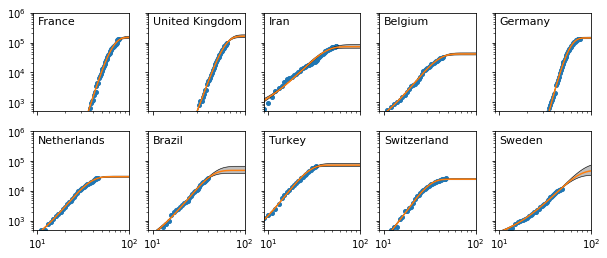

In [8]:
params_list = params_cases
data = cases
p0 = 500
daymin=-100
daymax=100
thresh = 500
c=0.95
drop_list = ['US','China','Italy','Spain']
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop(drop_list).loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e6))
    ax[k].set_xlim((9,1e2))
    ax[k].text(0.05,0.88,item[0],fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/global_pred_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot predictions for top US states

### Fatalities

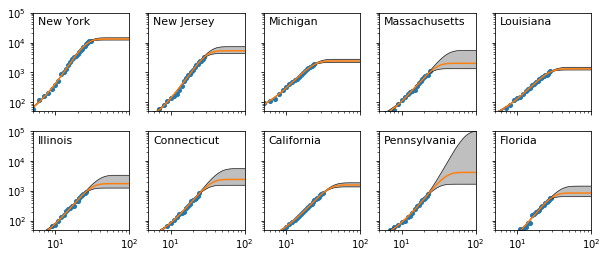

In [9]:
params_list = params_deaths.loc['US']
data = deaths['US']
p0 = 50
daymin=-100
daymax=100
c=0.95
current_fatalities = data.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e5))
    ax[k].set_xlim((5,1e2))
    ax[k].text(0.05,0.88,item,fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/US_pred.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

### Cases

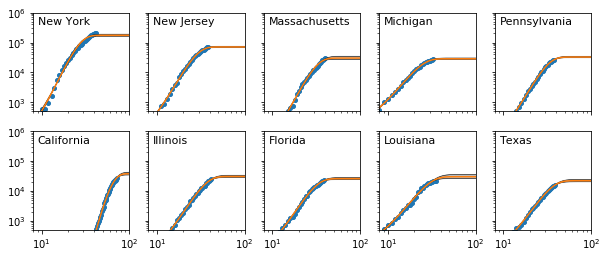

In [10]:
params_list = params_cases.loc['US']
data = cases['US']
p0 = 500
daymin=-100
daymax=100
c=0.95
current = data.iloc[-1]
current = current.sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((500,1e6))
    ax[k].set_xlim((8,1e2))
    ax[k].text(0.05,0.88,item,fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/US_pred_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Data collapse

## World > 500

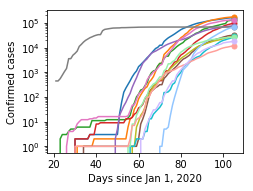

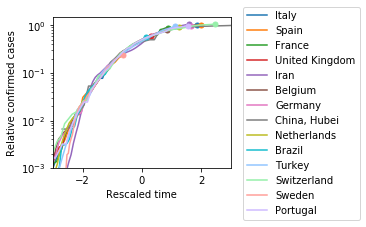

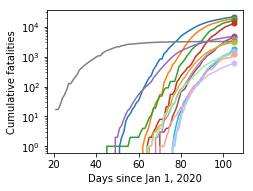

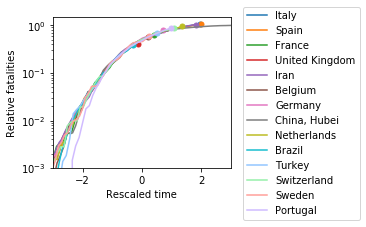

In [11]:
#Extract countries with current fatalities above threshold
thresh = 500
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop('US').loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index
colors = sns.color_palette()+sns.color_palette('pastel')

#Cases raw
fig,ax = data_collapse(cases,params_cases.loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
ax.set_ylabel('Confirmed cases')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Cases rescaled
fig,ax = data_collapse(cases,params_cases.loc[top_countries],endpoint=True,ms=5,colors=colors)
#Get legend plotted correctly
fig.set_figheight(3)
fig.set_figwidth(5.5)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative confirmed cases')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Fatalities raw
fig,ax = data_collapse(deaths,params_deaths.loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
ax.set_ylabel('Cumulative fatalities')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_deaths.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Fatalities rescaled
fig,ax = data_collapse(deaths,params_deaths.loc[top_countries],endpoint=True,ms=5,colors=colors)
#Get legend plotted correctly
fig.set_figheight(3)
fig.set_figwidth(5.5)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative fatalities')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_deaths.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## US > 500

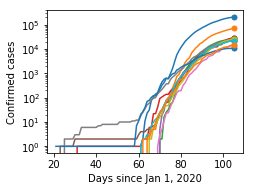

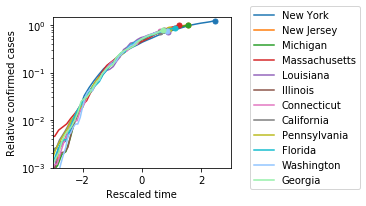

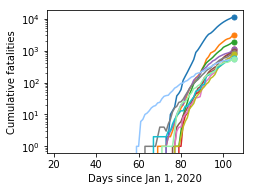

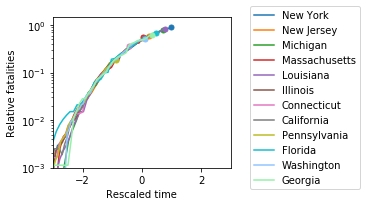

In [12]:
#Extract states with current fatalities above threshold
thresh = 500
current_fatalities = deaths['US'].iloc[-1]
current_fatalities = current_fatalities.loc[current_fatalities>thresh].sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current_fatalities.index

#Cases raw
fig,ax = data_collapse(cases['US'],params_cases.loc['US'].loc[top_countries],scale=False,endpoint=True,ms=5)
ax.set_ylabel('Confirmed cases')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_cases_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Cases rescaled
fig,ax = data_collapse(cases['US'],params_cases.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
#Get legend plotted correctly
fig.set_figheight(3)
fig.set_figwidth(5.5)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative confirmed cases')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_cases_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Fatalities raw
fig,ax = data_collapse(deaths['US'],params_deaths.loc['US'].loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
ax.set_ylabel('Cumulative fatalities')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_deaths_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Fatalities rescaled
fig,ax = data_collapse(deaths['US'],params_deaths.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
#Get legend plotted correctly
fig.set_figheight(3)
fig.set_figwidth(5.5)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative fatalities')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_deaths_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## All regions

### Fatalities

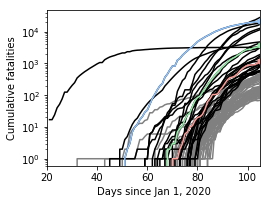

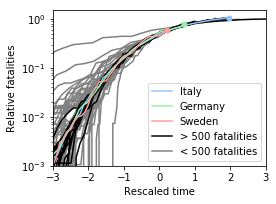

In [13]:
data = deaths
params_list = params_deaths
metric = 'fatalities' #For labels
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
thresh = 500

#Sort countries and set up colors
current = data.iloc[-1]
fit_countries = params_list.index.tolist()
current = current.loc[fit_countries].sort_values(ascending=True)
top_countries = current.index
colors_select = sns.color_palette('pastel')
colors = ['gray']*(current<=thresh).sum()+['black']*(current>thresh).sum()

#Raw
fig,ax=plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.16,bottom=0.16)
f,ax = data_collapse(data,params_list.loc[top_countries],scale=False,ax=ax,colors=colors)
f,ax = data_collapse(data,params_list.loc[select_countries],ax=ax,colors=colors_select,scale=False,endpoint=True,ms=5)
ax.set_xlim((20,(deaths.index[-1]-tref)/timedelta(days=1)))
ax.set_ylabel('Cumulative '+metric)
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_'+metric+'_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Rescaled
fig,ax=plt.subplots(figsize=(4,3))
f,ax = data_collapse(data,params_list.loc[top_countries],ax=ax,colors=colors,labels=False,alpha=1)
f,ax = data_collapse(data,params_list.loc[select_countries],ax=ax,colors=colors_select,endpoint=True,ms=5)
ax.plot([],[],'k',label='> '+str(thresh)+' '+metric)
ax.plot([],[],'gray',label='< '+str(thresh)+' '+metric)
fig.subplots_adjust(left=0.16,bottom=0.16)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative '+metric)
ax.set_xlabel('Rescaled time')
ax.legend()
pdf = bpdf.PdfPages('figures/after_collapse_'+metric+'_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

### Cases

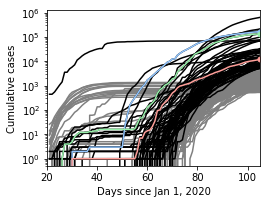

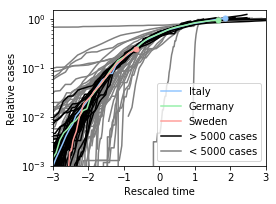

In [14]:
data = cases
params_list = params_cases
metric = 'cases' #For labels
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
thresh = 5000

#Sort countries and set up colors
current = data.iloc[-1]
fit_countries = params_list.index.tolist()
current = current.loc[fit_countries].sort_values(ascending=True)
top_countries = current.index
colors_select = sns.color_palette('pastel')
colors = ['gray']*(current<=thresh).sum()+['black']*(current>thresh).sum()

#Raw
fig,ax=plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.16,bottom=0.16)
f,ax = data_collapse(data,params_list.loc[top_countries],scale=False,ax=ax,colors=colors)
f,ax = data_collapse(data,params_list.loc[select_countries],ax=ax,colors=colors_select,scale=False,endpoint=True,ms=5)
ax.set_xlim((20,(deaths.index[-1]-tref)/timedelta(days=1)))
ax.set_ylabel('Cumulative '+metric)
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_'+metric+'_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Rescaled
fig,ax=plt.subplots(figsize=(4,3))
f,ax = data_collapse(data,params_list.loc[top_countries],ax=ax,colors=colors,labels=False,alpha=1)
f,ax = data_collapse(data,params_list.loc[select_countries],ax=ax,colors=colors_select,endpoint=True,ms=5)
ax.plot([],[],'k',label='> '+str(thresh)+' '+metric)
ax.plot([],[],'gray',label='< '+str(thresh)+' '+metric)
fig.subplots_adjust(left=0.16,bottom=0.16)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative '+metric)
ax.set_xlabel('Rescaled time')
ax.legend()
pdf = bpdf.PdfPages('figures/after_collapse_'+metric+'_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Simulations

In [ ]:
#Make graphs
N=1000  #Number of nodes
graphs = {'gamma_2.5':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 2.5), selfloops=False),
          'gamma_3':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 3), selfloops=False),
          'gamma_4':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 4), selfloops=False),
          'ER_2.5':nx.gnp_random_graph(N, 2.5/N),
          'ER_5':nx.gnp_random_graph(N, 5/N),
          'ER_10':nx.gnp_random_graph(N, 10/N)}

#Set up waiting time parameters
muG = 30 #Mean waiting time
sigG_list = {'Narrow waiting time distribution':muG/4,
            'Intermediate distribution':muG/2,
            'Broad waiting time distribution':muG}

tmax = 500
time_axis = [(datetime.today()-timedelta(days=tmax-k)).isoformat()[:10] for k in range(tmax)]
sim_data = pd.DataFrame(index=time_axis,columns=pd.MultiIndex.from_tuples([(item,name) for item in graphs.keys() for name in sigG_list.keys()]))

for item in sim_data.keys():
    print(item)
    t,cum_cases = simulate_pandemic_edges(graphs[item[0]],muG,sigG_list[item[1]],N_0=5,p=1,tmax=tmax,sampling='Gamma')
    sim_data[item] = cum_cases
sim_data.to_csv('output/simulation_small.csv')

----------gamma_2.5-----------


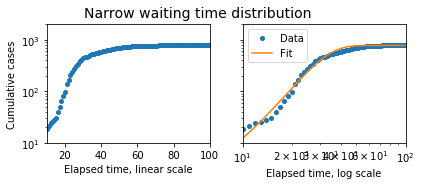

----------gamma_2.5-----------


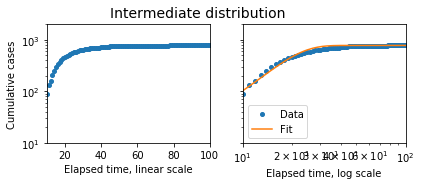

----------gamma_2.5-----------


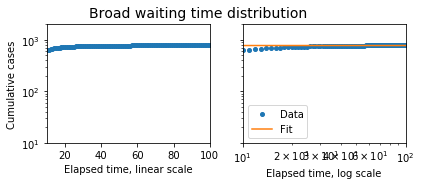

----------gamma_3-----------


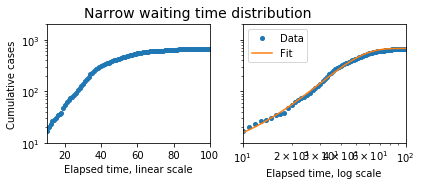

----------gamma_3-----------


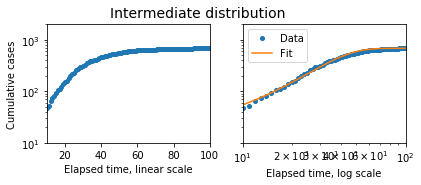

----------gamma_3-----------


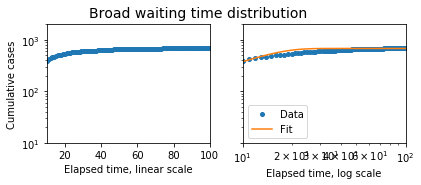

----------gamma_4-----------


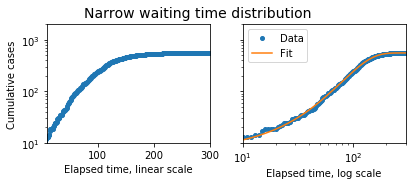

----------gamma_4-----------


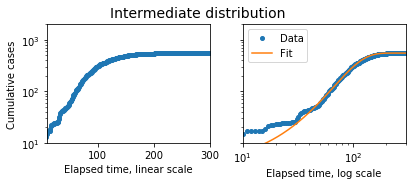

----------gamma_4-----------


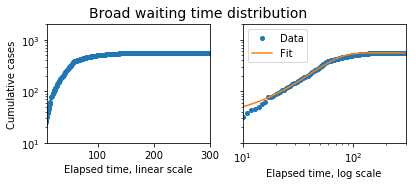

----------ER_2.5-----------


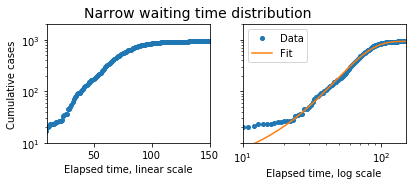

----------ER_2.5-----------


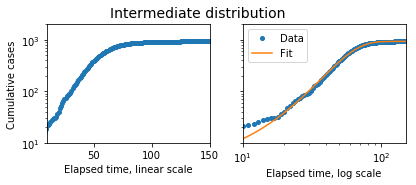

----------ER_2.5-----------


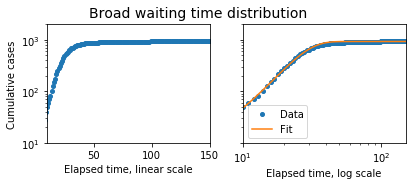

----------ER_5-----------


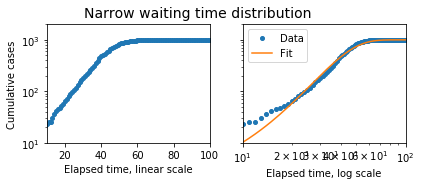

----------ER_5-----------


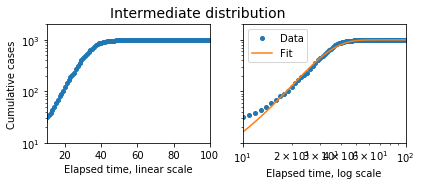

----------ER_5-----------


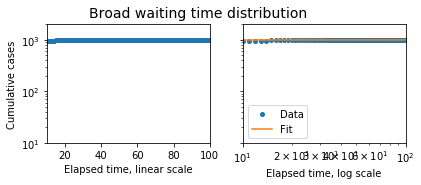

----------ER_10-----------


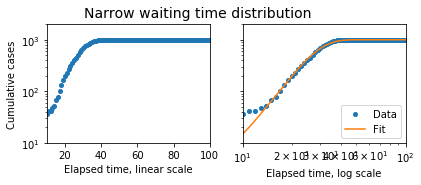

----------ER_10-----------


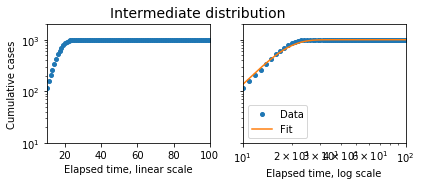

----------ER_10-----------


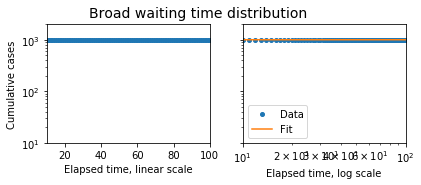

In [15]:
sim = load_sim('output/simulation_small.csv')
ms = 4
daymin=-500
daymax=100
k=0
start_cutoff=10
for item in sim.keys():
    #Set up axis limits
    if item[0] == 'gamma_4':
        tmax = 300
    elif item[0] == 'ER_2.5':
        tmax = 150
    else:
        tmax = 100
    print('----------'+item[0]+'-----------')
    
    #Fit to simulation
    data = sim[item]
    params,params0,success = fit_erf(data,p0=50)

    #Make predictions
    t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

    #Set up plot
    fig,ax=plt.subplots(1,2,sharey=True,figsize=(6,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    #Plot the data
    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    t_plot = plot_data.index.values
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)
    #Plot the predictions
    out = plot_predictions(data,params,ax=ax[1],log_scale=True,conf_type=None,p0=50,t_pred = t_pred,start_cutoff=start_cutoff)

    #Annotate
    ax[0].set_xlabel('Elapsed time, linear scale')
    ax[1].set_xlabel('Elapsed time, log scale')
    ax[0].set_ylabel('Cumulative cases')
    ax[0].set_ylim((10,2e3))
    fig.suptitle(item[1],fontsize=14)
    ax[1].legend()
    ax[0].set_xlim((10,tmax))
    ax[1].set_xlim((10,tmax))

    pdf = bpdf.PdfPages('figures/example_'+item[0]+'_'.join(item[1].split(' '))+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()
    k+=1

# Prediction is difficult until close to peak time

## Main plot

58.04390913102474
34.304884907277376
11.078584488052217
9.125777372055687
9.280332778728717


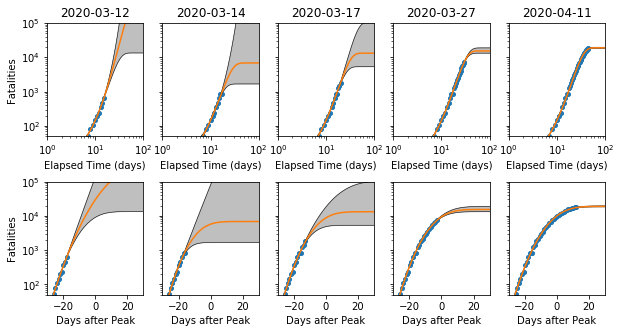

In [16]:
country = 'Italy'
region = 'NaN'

#Set up thresholds and prediction times
start_cutoff = 5
p0 = 50 #Minimum number of deaths before fitting begins
daymin = -100
daymax = 100
today = (datetime.today()-tref)/timedelta(days=1)
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

#Fit the data
data = deaths[country,region]
params,parm0,s = fit_erf(data,p0=p0)
th = params[0]

#Set up plots
fig,ax=plt.subplots(2,5,figsize=(10,5),sharex=False,sharey=True)
fig.subplots_adjust(hspace=0.4)

k=0
for days_after in [-15,-13,-10,0,15]:
    #Mask data after indicated date, and refit
    mask = int(-today+th+days_after)
    params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
    
    #Plot predictions and uncertainties with masked data on log-log and log-linear
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[0,k],
                                     p0=p0,log_scale=True,start_cutoff=start_cutoff,c=0.95)
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[1,k],
                                     p0=p0,log_scale=False,c=0.95)
    #Print to show progress
    print(params_good[-1,2])
    
    #Annotate
    ax[0,k].set_ylim((p0,1e5))
    ax[1,k].set_ylim((p0,1e5))
    ax[0,k].set_xlim((1,100))
    ax[1,k].set_xlim((-30,30))
    ax[0,k].set_xlabel('Elapsed Time (days)')
    ax[1,k].set_xlabel('Days after Peak')
    ax[0,k].set_title((tref+timedelta(days=th+days_after)).isoformat()[:10])
    k+=1
ax[0,0].set_ylabel('Fatalities')
ax[1,0].set_ylabel('Fatalities')
pdf = bpdf.PdfPages('figures/'+country+'_forecasting.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Inset

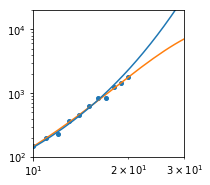

In [17]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.2)
p0 = 50
t0 = (data.loc[data>start_cutoff].index[0]-tref)/timedelta(days=1)
mask = int(-today+th-10)
params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type=None,th_true=th,ax=ax,
                                 p0=p0,log_scale=True,start_cutoff=start_cutoff,c=0.95)
mask = int(-today+th-13)
params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
params_sweep = sweep_sigma(params,data.iloc[:mask],p0)
sigma,prob,scoremax = get_score_thresh(params_sweep,len(data.iloc[:mask].loc[data.iloc[:mask]>p0]),c)
params_good = params_sweep[params_sweep[:,3]<=scoremax]
t = np.linspace(1,200,1000)
tau = (t-params_good[-1,0])/params_good[-1,2]
ax.plot(t-t0,np.exp(params_good[-1,1])*norm.cdf(tau))
ax.set_xlim((10,30))
ax.set_ylim((1e2,2e4))
ax.set_xlabel('')
pdf = bpdf.PdfPages('figures/'+country+'_forecasting_in.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Parameters

## Plot countries

### Fatalities (sigma and th)

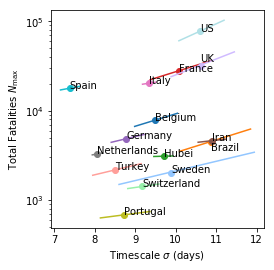

In [18]:
thresh = 500
#Find countries above threshold (treat US separately, because of indexing issue)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()
colors = sns.color_palette()+sns.color_palette('pastel')

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    #Adjust text location for countries that overlap
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],1.1*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    #Plot data and error bars
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
k+=1 #(US is yellow and hard to see otherwise)
#Same for US
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])

#Annotate
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total Fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_sigma.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

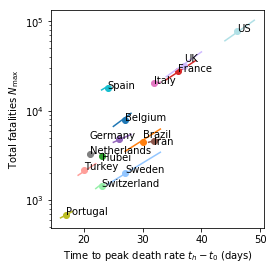

In [21]:
thresh = 500
start_cutoff = 5 #Need this to estimate t0

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()
colors = sns.color_palette()+sns.color_palette('pastel')

k=0
for item in top_countries:
    #Estimate t0
    t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
    #Get t-t0 and confidence bounds
    tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)
    
    #Shift annotations when necessary
    if item[0] == 'United Kingdom':
        ax.annotate('UK',(tht0,1.1*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(tht0-5,predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(tht0,0.9*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Iran':
        ax.annotate(item[0],(tht0,0.9*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Brazil':
        ax.annotate(item[0],(tht0,1.1*predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(tht0,predictions_deaths['Nmax'].loc[item]))
        
    #Plot data and error bars
    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
k+=1
#Same for US
item = ('US','NaN')
t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)
ax.annotate('US',(tht0,predictions_deaths['Nmax'].loc[item]))
ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])

#Labels
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

### Cases (just sigma for now)

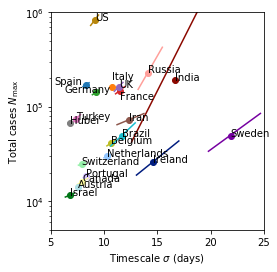

In [22]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_cases = cases.iloc[-1].sort_index().drop('US')
top_countries = current_cases.loc[current_cases>5000].sort_values(ascending=False).index.tolist()[:20]
k=0
colors = sns.color_palette()+sns.color_palette('pastel')+sns.color_palette('dark')
for item in top_countries:
    if item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    elif item[0] in ['Spain','Germany']:
        ax.annotate(item[0],(predictions_cases['sigma'].loc[item]-3,predictions_cases['Nmax'].loc[item]))
    elif item[0] == 'Italy':
        ax.annotate(item[0],(predictions_cases['sigma'].loc[item],1.2*predictions_cases['Nmax'].loc[item]))
    elif item[0] == 'France':
        ax.annotate(item[0],(predictions_cases['sigma'].loc[item],0.8*predictions_cases['Nmax'].loc[item]))
    elif item[0] in ['Japan','Peru']:
        ax.annotate(item[0],(predictions_cases['sigma_low'].loc[item],predictions_cases['Nmax_low'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
item = ('US','NaN')
ax.annotate('US',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
ax.set_ylim((5000,1e6))
ax.set_xlim((5,25))
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot states

### Fatalities (sigma and th)

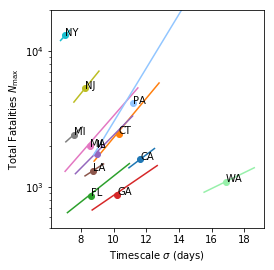

In [23]:
#Load state abbreviations for annotating plots
abbreviations = pd.read_csv('input/state_list.csv',index_col=0).squeeze().to_dict()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_fatalities.sort_index().loc[current_fatalities>500].index.tolist()
k=0
colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item == 'Illinois':
        ax.annotate(abbreviations[item],(predictions_deaths['sigma'].loc['US',item],1.1*predictions_deaths['Nmax'].loc['US',item]))
    else:
        ax.annotate(abbreviations[item],(predictions_deaths['sigma'].loc['US',item],predictions_deaths['Nmax'].loc['US',item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc['US',item],predictions_deaths['sigma_high'].loc['US',item]],[predictions_deaths['Nmax_low'].loc['US',item],predictions_deaths['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc['US',item]],[predictions_deaths['Nmax'].loc['US',item]],'o',color=colors[k],label=item[0])
    k+=1
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total Fatalities $N_{\rm max}$')
ax.set_ylim((500,20000))
pdf = bpdf.PdfPages('figures/top_US_scatter.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

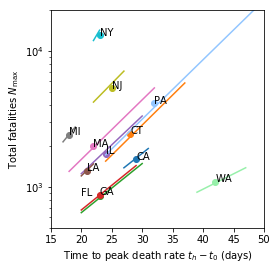

In [24]:
#Load state abbreviations for annotating plots
abbreviations = pd.read_csv('input/state_list.csv',index_col=0).squeeze().to_dict()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_fatalities.sort_index().loc[current_fatalities>500].index.tolist()
k=0
colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    t0 = deaths.loc[deaths['US',item]>start_cutoff].index[0]
    tht0 = (predictions_deaths['th'].loc['US',item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc['US',item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc['US',item]-t0)/timedelta(days=1)
    if item == 'Florida':
        ax.annotate(abbreviations[item],(tht0-3,predictions_deaths['Nmax'].loc['US',item]))
    else:
        ax.annotate(abbreviations[item],(tht0,predictions_deaths['Nmax'].loc['US',item]))
    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc['US',item],predictions_deaths['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc['US',item]],'o',color=colors[k],label=item)
    k+=1
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylim((500,20000))
ax.set_xlim((15,50))
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_US_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

### Cases (just sigma for now)

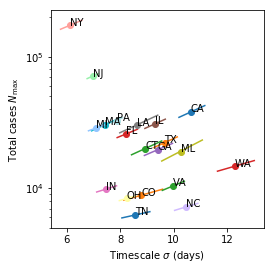

In [25]:
#Load state abbreviations for annotating plots
abbreviations = pd.read_csv('input/state_list.csv',index_col=0).squeeze().to_dict()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_cases = cases.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_cases.sort_index().loc[current_cases>5000].index.tolist()
k=0
colors = (sns.color_palette()+sns.color_palette('pastel'))*10
for item in top_countries:
    ax.annotate(abbreviations[item],(predictions_cases['sigma'].loc['US',item],predictions_cases['Nmax'].loc['US',item]))
    ax.semilogy([predictions_cases['sigma_low'].loc['US',item],predictions_cases['sigma_high'].loc['US',item]],[predictions_cases['Nmax_low'].loc['US',item],predictions_cases['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc['US',item]],[predictions_cases['Nmax'].loc['US',item]],'o',color=colors[k],label=item[0])
    k+=1
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
#ax.set_ylim((500,20000))
pdf = bpdf.PdfPages('figures/top_US_scatter_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Color by current total number

### Fatalities (sigma and th)

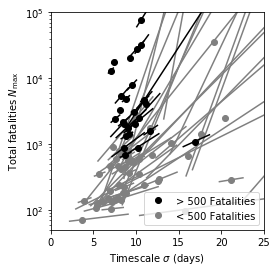

In [26]:
thresh = 500

#Sort countries and assign colors
current_fatalities = deaths.iloc[-1].sort_index()
fit_countries = predictions_deaths.index #Use all countries that have fits
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=True)
top_countries = current_fatalities.index
colors = ['gray']*(current_fatalities<=thresh).sum()+['black']*(current_fatalities>thresh).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k])
    k+=1
ax.plot([],[],'o',color='k',label='> '+str(thresh)+' Fatalities')
ax.plot([],[],'o',color='gray',label='< '+str(thresh)+' Fatalities')
ax.legend()
ax.set_xlim((0,25))
ax.set_ylim((50,1e5))
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/all_scatter.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

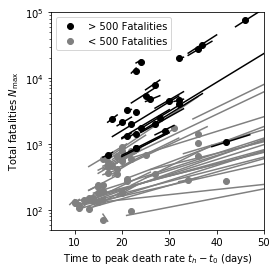

In [27]:
thresh = 500
current_fatalities = deaths.iloc[-1].sort_index()
fit_countries = predictions_deaths.index #Use all countries that have fits
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=True)
top_countries = current_fatalities.index
colors = ['gray']*(current_fatalities<=500).sum()+['black']*(current_fatalities>500).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
    tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)

    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k])
    k+=1
ax.plot([],[],'o',color='k',label='> '+str(thresh)+' Fatalities')
ax.plot([],[],'o',color='gray',label='< '+str(thresh)+' Fatalities')
ax.legend()
ax.set_xlim((5,50))
ax.set_ylim((50,1e5))
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/all_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
#ax.legend()
plt.show()

### Cases

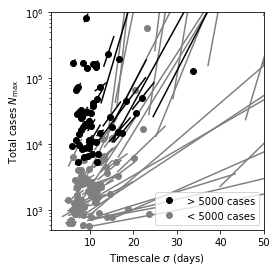

In [28]:
thresh = 5000
current_cases = cases.iloc[-1].sort_index()
fit_countries = predictions_cases.index
current_cases = current_cases.loc[fit_countries].sort_values(ascending=True)
top_countries = current_cases.index
colors = ['gray']*(current_cases<=thresh).sum()+['black']*(current_cases>thresh).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k])
    k+=1

ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
ax.set_xlim((1,50))
ax.set_ylim((500,1e6))
ax.plot([],[],'o',color='k',label='> '+str(thresh)+' cases')
ax.plot([],[],'o',color='gray',label='< '+str(thresh)+' cases')
ax.legend()
pdf = bpdf.PdfPages('figures/top_world_scatter_cases_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Social policy

First, we have to load the OxCGRT data and format it.

In [29]:
start_cutoff=5 #Need this to compute t0
#Need these to convert OxCGRT dates:
month_numbers = {'jan':'01',
                 'feb':'02',
                 'mar':'03',
                 'apr':'04',
                 'may':'05'}

#Read the stringency index and format the dates
stringency = pd.read_excel('input/OxCGRT_timeseries_all.xlsx',sheet_name='stringencyindex',index_col=0).T.drop('CountryCode')
new_index = []
for k in range(len(stringency.index)):
    item = stringency.index[k]
    new_index.append('-'.join([item[-4:],month_numbers[item[2:5]],item[:2]]))
stringency.index = pd.to_datetime(new_index)

#Can make some aggregate scores based on max, or median since some date
strin_score_med = stringency.loc[datetime(2020,3,1):].median()
strin_score_max = stringency.max()

#Define the time from beginning (deaths > start_cutoff) to stringency threshold (s_thresh)
s_thresh=75
sd_time = pd.Series(np.ones(len(stringency.T))*np.nan,index=stringency.keys())
for item in sd_time.index:
    #Find countries have names that agree in both JH and OxCGRT indices
    if (item,'NaN') in deaths.T.index.tolist():
        if (deaths[(item,'NaN')]>=start_cutoff).sum()>0:
            #Compute t0 for the country
            t0 = deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0]
            if (stringency[item]>s_thresh).sum()>0:
                #If country reaches the stringency threshold, calculate the time elapsed since t0
                sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)
            else:
                #If the country never reaches the threshold, put a large number
                sd_time.loc[item] = 1000
    #China really means the Hubei province for our purposes
    elif item == 'China':
        t0 = deaths[(item,'Hubei')].loc[deaths[(item,'Hubei')]>=start_cutoff].index[0]
        sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)
    #Need to treat the US separately because the whole country and the states are both
    #in our table
    elif item == 'United States':
        t0 = deaths[('US','NaN')].loc[deaths[('US','NaN')]>=start_cutoff].index[0]
        sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)

#Can also calculate the time until specific events like work closures happen    
work_close = pd.read_excel('input/OxCGRT_timeseries_all.xlsx',sheet_name='s2_workplaceclosing',index_col=0).T.drop('CountryCode')
new_index = []
for k in range(len(work_close.index)):
    item = work_close.index[k]
    new_index.append('-'.join([item[-4:],month_numbers[item[2:5]],item[:2]]))
work_close.index = pd.to_datetime(new_index)
work_time = pd.Series(np.ones(len(work_close.T))*np.nan,index=work_close.keys())
for item in work_time.index:
    if (item,'NaN') in deaths.T.index.tolist():
        if (deaths[(item,'NaN')]>=start_cutoff).sum()>0:
            if work_close[item].sum()>0:
                work_time.loc[item] = (work_close[item].loc[work_close[item]>0].index[0]
                                     -deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0])/timedelta(days=1)
            else:
                work_time.loc[item] = (work_close.index[-1]-deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0])/timedelta(days=1)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Let's see how much variability there is in the stringency patterns:

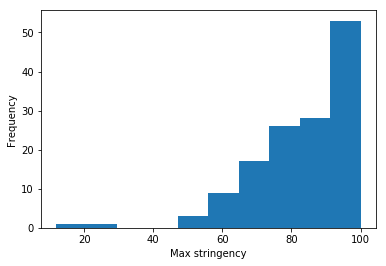

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


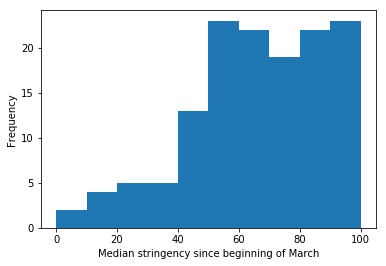

In [30]:
stringency.max().plot.hist()
plt.gca().set_xlabel('Max stringency')
plt.show()

stringency.loc[datetime(2020,3,1):].median().plot.hist()
plt.gca().set_xlabel('Median stringency since beginning of March')
plt.show()

## Absolute fatalities

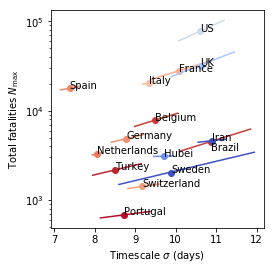

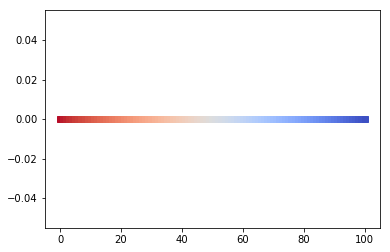

In [31]:
#Choose score and load the data
strin_score = sd_time #The stringency score to use
smin = 0 #Level to set as minimum on color bar
smax = 40 #Level to set as max on color bar
colors = sns.color_palette('coolwarm_r',101)
thresh = 500 #Threshold for including countries
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()

#Set up the colors
strin_score = strin_score-smin
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-smin)
strin_score[strin_score>100] = 100

ms = 6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc['United States'])])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_str_time.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

#Make a color bar
fig,ax=plt.subplots()
klist = np.arange(101)
for k in klist:
    ax.plot([k],[0],'s',color=colors[k])
pdf = bpdf.PdfPages('figures/colorbar.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

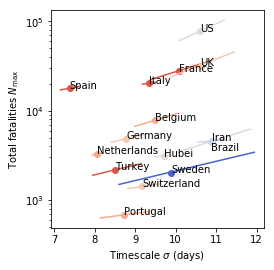

In [32]:
#Choose score and load the data
strin_score = strin_score_max #The stringency score to use
smin = 50 #Level to set as minimum on color bar
smax = 100 #Level to set as max on color bar
colors = sns.color_palette('coolwarm',101) #colors
thresh = 500 #Threshold for including countries
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()

#Set up the colors
strin_score = strin_score-smin
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-smin)
strin_score[strin_score>100] = 100

ms = 6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc['United States'])])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_str.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Per-capita fatalities

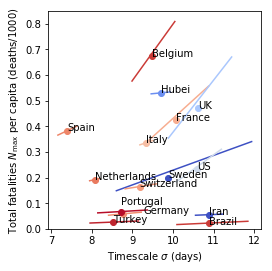

In [33]:
#Choose score and load the data
strin_score = sd_time #The stringency score to use
smin = 0 #Level to set as minimum on color bar
smax = 40 #Level to set as max on color bar
colors = sns.color_palette('coolwarm_r',101) #colors
thresh = 500 #Threshold for including countries
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()

#Set up the colors
strin_score = strin_score-smin
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-smin)
strin_score[strin_score>100] = 100

#Make per-capita data
populations = pd.to_numeric(pd.read_csv('input/populations.csv').fillna(value='NaN').set_index(['Country/Region','Province/State']).squeeze())
predictions_pc = predictions_deaths.copy().loc[top_countries]
for item in ['Nmax','Nmax_low','Nmax_high']:
    #Measure by deaths per thousand
    predictions_pc[item] = 1000*predictions_pc[item]/populations.loc[predictions_pc.index.tolist()]

ms=6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],0.8*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Portugal':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],1.4*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(0.5+predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    ax.plot([predictions_pc['sigma_low'].loc[item],predictions_pc['sigma_high'].loc[item]],[predictions_pc['Nmax_low'].loc[item],predictions_pc['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.plot([predictions_pc['sigma'].loc[item]],[predictions_pc['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
#Same for US
item = ('US','NaN')
predictions_pc = predictions_deaths.copy().loc[item]
for col in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[col] = 1000*predictions_pc[col]/populations.loc[item]
ax.annotate('US',(predictions_pc['sigma'],predictions_pc['Nmax']))
ax.plot([predictions_pc['sigma_low'],predictions_pc['sigma_high']],[predictions_pc['Nmax_low'],predictions_pc['Nmax_high']],color=colors[int(strin_score.loc['United States'])])
ax.plot([predictions_pc['sigma']],[predictions_pc['Nmax']],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$ per capita (deaths/1000)')
ax.set_ylim((0,None))
pdf = bpdf.PdfPages('figures/top_world_scatter_str_time_pc.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

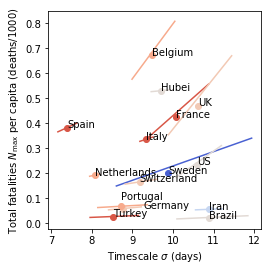

In [34]:
#Choose score and load the data
strin_score = strin_score_max #The stringency score to use
smin = 50 #Level to set as minimum on color bar
smax = 100 #Level to set as max on color bar
colors = sns.color_palette('coolwarm',101) #colors
thresh = 500 #Threshold for including countries
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()

#Set up the colors
strin_score = strin_score-smin
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-smin)
strin_score[strin_score>100] = 100

#Make per-capita data
populations = pd.to_numeric(pd.read_csv('input/populations.csv').fillna(value='NaN').set_index(['Country/Region','Province/State']).squeeze())
predictions_pc = predictions_deaths.copy().loc[top_countries]
for item in ['Nmax','Nmax_low','Nmax_high']:
    #Measure by deaths per thousand
    predictions_pc[item] = 1000*predictions_pc[item]/populations.loc[predictions_pc.index.tolist()]

ms=6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],0.8*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Portugal':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],1.4*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(0.5+predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    ax.plot([predictions_pc['sigma_low'].loc[item],predictions_pc['sigma_high'].loc[item]],[predictions_pc['Nmax_low'].loc[item],predictions_pc['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.plot([predictions_pc['sigma'].loc[item]],[predictions_pc['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
    k+=1
item = ('US','NaN')
predictions_pc = predictions_deaths.copy().loc[item]
for col in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[col] = 1000*predictions_pc[col]/populations.loc[item]
ax.annotate('US',(predictions_pc['sigma'],predictions_pc['Nmax']))
ax.plot([predictions_pc['sigma_low'],predictions_pc['sigma_high']],[predictions_pc['Nmax_low'],predictions_pc['Nmax_high']],color=colors[int(strin_score.loc['United States'])])
ax.plot([predictions_pc['sigma']],[predictions_pc['Nmax']],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$ per capita (deaths/1000)')
pdf = bpdf.PdfPages('figures/top_world_scatter_str_pc.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Compare predictions

First we need to format the data from IHME:

In [35]:
IHME = pd.read_csv('input/2020_04_12.02/Hospitalization_all_locs.csv')
IHME['date'] = pd.to_datetime(IHME['date'],format='%Y-%m-%d')
IHME_predictions = pd.DataFrame(index=predictions_deaths.index,columns=['Nmax','Nmax_low','Nmax_high','th','th_low','th_high'])

#Extract Nmax as max of totdea
Nmax = IHME.pivot_table(index='date',values='totdea_mean',columns='location_name').max()
Nmax_high = IHME.pivot_table(index='date',values='totdea_upper',columns='location_name').max()
Nmax_low = IHME.pivot_table(index='date',values='totdea_lower',columns='location_name').max()

#Extract th as argmax of deaths
th = (IHME.pivot_table(index='date',values='deaths_mean',columns='location_name').idxmax()).dt.strftime('%Y-%m-%d')
th_high = (IHME.pivot_table(index='date',values='deaths_upper',columns='location_name').idxmax())
th_low = (IHME.pivot_table(index='date',values='deaths_lower',columns='location_name').idxmax())

#Construct table of predictions
for name in set(IHME['location_name']):
    if name in deaths.T.loc['US'].index.tolist():
        item = ('US',name)
    else:
        item = (name,'NaN')
    if item in IHME_predictions.index.tolist():
        IHME_predictions.loc[item] = [Nmax.loc[name],Nmax_low.loc[name],Nmax_high.loc[name],
                                      th.loc[name],th_low.loc[name],th_high.loc[name]]
#Save for future reference
IHME_predictions.to_csv('output/IHME_predictions.csv')

## World

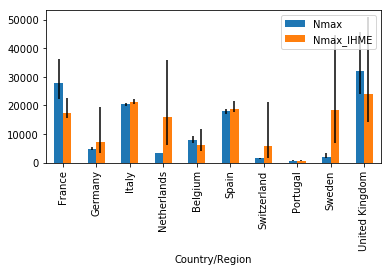

In [36]:
#Load fatalities and drop province index
thresh = 500
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>thresh].reset_index().set_index('Country/Region').index.tolist()

#Join tables to make comparison
pred_compare = predictions_deaths.join(IHME_predictions,rsuffix='_IHME').dropna().reset_index().T.drop('Province/State').T.set_index('Country/Region')
#Extract countries above threshold that are also in the IHME list
valid_regions = list(set(top_countries).intersection(set(pred_compare.index.tolist())))

#Construct error bars
pred_plot = pred_compare[['Nmax','Nmax_IHME']].loc[valid_regions]
bottom = pred_plot['Nmax'].values - pred_compare['Nmax_low'].loc[valid_regions].values
top = pred_compare['Nmax_high'].loc[valid_regions].values - pred_plot['Nmax'].values
bottom_IHME = pred_plot['Nmax_IHME'].values - pred_compare['Nmax_low_IHME'].loc[valid_regions].values
top_IHME = pred_compare['Nmax_high_IHME'].loc[valid_regions].values - pred_plot['Nmax_IHME'].values
pred_err = np.asarray([np.vstack((bottom.T,top.T)),np.vstack((bottom_IHME.T,top_IHME.T))])

#Make the plot
fig,ax=plt.subplots()
fig.subplots_adjust(bottom=0.35)
pred_plot.plot.bar(ax=ax,yerr=pred_err)
pdf = bpdf.PdfPages('figures/IHME_world.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## US

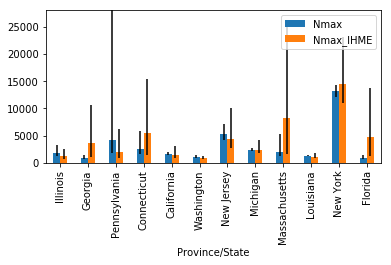

In [38]:
#Load fatalities for US
thresh = 500
current_fatalities = deaths.iloc[-1].sort_index().loc['US'].drop('NaN')
top_countries = current_fatalities.loc[current_fatalities>thresh].index.tolist()
#Join IHME tables with our predictions, after dropping country index
pred_compare = predictions_deaths.join(IHME_predictions,rsuffix='_IHME').dropna().reset_index().T.drop('Country/Region').T.set_index('Province/State')
#Extract states that are above threshold and also in IHME list (should be all the ones above threshold)
valid_regions = list(set(top_countries).intersection(set(pred_compare.index.tolist())))

#Make error bars
pred_plot = pred_compare[['Nmax','Nmax_IHME']].loc[valid_regions]
bottom = pred_plot['Nmax'].values - pred_compare['Nmax_low'].loc[valid_regions].values
top = pred_compare['Nmax_high'].loc[valid_regions].values - pred_plot['Nmax'].values
bottom_IHME = pred_plot['Nmax_IHME'].values - pred_compare['Nmax_low_IHME'].loc[valid_regions].values
top_IHME = pred_compare['Nmax_high_IHME'].loc[valid_regions].values - pred_plot['Nmax_IHME'].values
pred_err = np.asarray([np.vstack((bottom.T,top.T)),np.vstack((bottom_IHME.T,top_IHME.T))])

#Plot
fig,ax=plt.subplots()
fig.subplots_adjust(bottom=0.35)
pred_plot.plot.bar(ax=ax,yerr=pred_err)
ax.set_ylim((None,28000))
pdf = bpdf.PdfPages('figures/IHME_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Methods

First, we show that the distribution is effectively one-dimensional. We start by computing the Hessian.

In [40]:
country = 'Italy'
region = 'NaN'
p0 = 50

#Go 15 days before peak
today = (deaths.index[-1]-tref)/timedelta(days=1)
th = params_deaths.loc[country,region]['th']
days_back=15
mask = int(today-th+days_back)
data = deaths[country,region].iloc[:-mask]

#Fit the data
params,parm0,s = fit_erf(data,p0=p0)

#Compute the Hessian
train = pd.to_numeric(data.loc[data>p0])
train.index=(train.index-tref)/timedelta(days=1)
sig_xi2 = params[-1]
H = hess_p(params[:-1],train,None)

#Look at the spectrum
print(np.linalg.eig(H))

#Marginalize over th
H = np.linalg.inv(H)[1:,:]
H = np.linalg.inv(H[:,1:])

(array([1.73530006e+01, 9.11599501e-05, 3.57590112e-01]), array([[ 0.2374368 , -0.96733364, -0.08882232],
       [-0.82796713, -0.15370916, -0.53929948],
       [-0.50802973, -0.2015915 ,  0.83741666]]))


Now we use the Hessian to generate the Gaussian approximation for the posterior probability over log $N_{\rm max}$ and $\sigma$ (we marginalized out $t_h$ in the last step above):

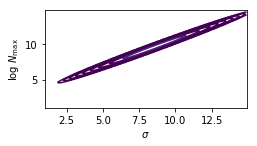

In [41]:
delta = 0.1
sigma = np.arange(1, 15, delta)
logK = np.arange(1, 15, delta)
X, Y = np.meshgrid(sigma, logK)
logK0 = params[1]
sig0 = params[2]
C = [[(np.asarray([Y[j,k]-logK0,X[j,k]-sig0])[np.newaxis,:].dot(H.dot(np.asarray([Y[j,k]-logK0,X[j,k]-sig0])))).squeeze() 
      for k in range(len(X.T))] for j in range(len(X))]

fig,ax=plt.subplots(figsize=(4,2))
fig.subplots_adjust(bottom=0.2,left=0.2)
levels = np.logspace(-9,0,10)
ax.contour(X,Y,np.exp(-np.asarray(C/sig_xi2)),levels=levels)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'log $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/hessian.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

Finally, we look at the full, non-Gaussian distribution over $\sigma$, confining ourselves to the 1-dimensional ridge where $t_h$ and $N_{\rm max}$ are assigned their best-fit values at each value of $\sigma$:

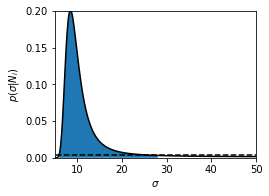

In [42]:
fig,ax=plt.subplots(figsize=(4,3))
fig.subplots_adjust(bottom=0.2,left=0.2)
c = 0.95
M = len(train)
params_sweep = sweep_sigma(params,data,p0)
sigma, prob,scoremax = get_score_thresh(params_sweep,M,0.95)
ax.plot(sigma,prob,'k')
score = params_sweep[1:,3]
ax.fill_between(sigma[score<=scoremax],prob[score<=scoremax])

sigma = params_sweep[:,2]
dsig = np.diff(sigma)
sigma = sigma[1:]
pcut = np.exp(-scoremax*M/(2*sig_xi2))/(np.exp(-score*M/(2*sig_xi2))*dsig).sum()
ax.plot([0,50],[pcut,pcut],'k--')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|N_i)$')
ax.set_xlim((5,50))
ax.set_ylim((0,0.2))
pdf = bpdf.PdfPages('figures/psig.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()
plt.show()

Zoom in to see better:

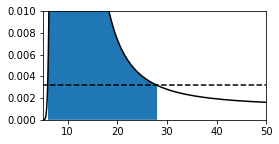

In [43]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(sigma,prob,'k')
ax.fill_between(sigma[score<=scoremax],prob[score<=scoremax])
pcut = np.exp(-scoremax*M/(2*sig_xi2))/(np.exp(-score*M/(2*sig_xi2))*dsig).sum()
ax.plot([0,50],[pcut,pcut],'k--')

ax.set_xlim((5,50))
ax.set_ylim((0,0.01))
pdf = bpdf.PdfPages('figures/psig_in.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()
plt.show()